The following analysis is going to be made on SIFT1M dataset which is a collection of images.  
For a given image from the **test set**, the algorithms try to find 100 most similar images in the **training set** - e.g. 100 nearest neighbours.  
When the search is done, we compare the result with **gound truth set** that holds reference to 100 EXACTLY most similar images - e.g. 100 true nearest neighbours.  
Remember that algorithms search is aproximate - not exact, so if alghoritm finds 86 out of 100 true neighbours, we say it's **recall** is 86%. 

In the following lines, we're gonna:
1. Do boring stuff: Import libraries, prepare data etc.
2. Run different alghoritams under various parameters to compare them
3. Do interesting stuff: Visualise results & give comments

In [0]:
import numpy as np
import pandas as pd
import os
import struct
import time
from time import process_time
from itertools import chain 
import gc
import psutil
import tarfile
import urllib
import matplotlib.pyplot as plt

SIFT dataset is a collection of images turned into numbers (vectors) that represent images the best.  
To find out more about the structure of the datasets, visit http://corpus-texmex.irisa.fr/

Since data is zipped and stored in a (boring) binary format, we defined helper functions to read them (get_zippedFvecs & get_zippedIvecs).

In [0]:
#We are going to download data from following url
url = "ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz"
#When downloaded, datasets will be stored on following local paths
paths =  '/tmp/sift.tar.gz' 
trainPath = 'sift/sift_base.fvecs'
queryPath = 'sift/sift_query.fvecs'
groundPath = 'sift/sift_groundtruth.ivecs'
#We can dowload binary dataset directly to our folder in Databricks
urllib.request.urlretrieve(url, paths)

Out[2]: ('/tmp/sift.tar.gz', <email.message.Message at 0x7fda0e29c6d0>)

In [0]:
def get_zippedFvecs(pathToGz,memeber):
    fn = pathToGz
    t = tarfile.open(fn, 'r:gz') 
    
    m = t.getmember(memeber)
    file = t.extractfile(m)
    fileSize = m.size
    #first 4 bytes of every vector indicate number od dimensions 
    numOfDimensions = struct.unpack('i', file.read(4))[0]
    #each vector has 4 bytes (float is 32 bits) * numberOfDimensions
    #plus 4 bytes long indicator as mentioned  
    numOfVectors = (int) (fileSize / (4 + 4*numOfDimensions))
    #init empty list for vectors
    vectors = np.zeros((numOfVectors,numOfDimensions))
    #return to the beginning
    file.seek(0)
    for vecotr in range(numOfVectors):
        file.read(4) #go trough indicator of dimensions
        vectors[vecotr] = struct.unpack('f' * numOfDimensions, file.read(4*numOfDimensions))
    file.close()
    return vectors

In [0]:
def get_zippedIvecs(pathToGz,memeber):
    fn = pathToGz
    t = tarfile.open(fn, 'r:gz') 
    
    m = t.getmember(memeber)
    file = t.extractfile(m)
    fileSize = m.size
    #first 4 bytes of every vector indicate number od dimensions 
    numOfDimensions = struct.unpack('i', file.read(4))[0]
    #each vector has 4 bytes (float is 32 bits) * numberOfDimensions
    #plus 4 bytes long indicator as mentioned  
    numOfVectors = (int) (fileSize / (4 + 4*numOfDimensions))
    #init empty list for vectors
    #vectors = []
    vectors = np.zeros((numOfVectors,numOfDimensions),int)
    #return to the beginning
    file.seek(0)
    for vecotr in range(numOfVectors):
        file.read(4) #go trough indicator of dimensions
        vectors[vecotr] = struct.unpack('i' * numOfDimensions, file.read(4*numOfDimensions))
    file.close()
    return vectors

In [0]:
train = get_zippedFvecs(paths,trainPath )
#there is 100 querry ponts
query = get_zippedFvecs(paths,queryPath )
#there is index number of 100 nearset n. for each querry point
groundTruth = get_zippedIvecs(paths,groundPath )

In [0]:
def returnRecall(result, test):
    numOfTrueNeighbours = []
    #for every result vector we check how many right neighbours were identified
    for i in range(result.shape[0]):
        numTN = len(set(result[i].tolist()) & set(test[i].tolist()))
        numOfTrueNeighbours.append(numTN)
        recall = sum(numOfTrueNeighbours) /test.size
    return recall

In [0]:
def fillIfNotAllAreFound(result):
    for i in range(len(result)):
        if len(result[i]) < 100: 
            result[i].extend((100-len(result[i])) *[-1]) 
    return result

In [0]:
def getUsedMemory():
  return round(psutil.virtual_memory()._asdict()['used'] / (1024)**3, 2)

In [0]:
rm /tmp/sift.tar.gz

Three approximating algorithms(techniques) for finding nearest neighbours will be tested:  
1. Annoy  
2. LSH  
3. HNSW

To compare different algorithms it makes sence to use following KPIs:
1. **Recall**  
   As mentioned before, recall tells how good the approximating algorithm identifies TRUE neighbours.  
   So, if algorithm finds 77 true neighbours and a 23 that are not really in top 100 closest neighbours, we say it's recall is 0.77 or 77%  
   
2. **Construction time** (preprocessing time) in seconds  
    Approximating algsorithms have to do preprocessing of data to create data structures that are suitable for fast search.  
    Annoy does it by creating tree like data structures,  
    LSH uses hashing functions to group instances into smaller buckets, while HNSW uses graph like structures.  
    
3. **Search time** in seconds  
    Lets remember the example from a beginnig of the script. 
    We have an image and we want to find top 100 most similar images to the one we have.  
    We want to get our results as soon as posible, but we are searching data set of million images.  
    Thats why the algorithm constructed a special data structure in the previous step - so we can find our top 100 most similar images fastly.  
    There is usualy a tradeoff between **Recall** and **Search time**. Longer the search - more true neighbours found.

In [0]:
algorithm = []
reacll = []
construciotnTimes=[]
searchTimes=[]
k = 100
avgdistances = []
constructionClocks = []
searchClocks = []
clockAlg = []
memoryConsumptions = []

In [0]:
#Annoy
searchKparam = []
numTreesParam = []
constructionClocks = []
searchClocks = []
clockAlg = []

In [0]:
from annoy import AnnoyIndex

for trees in [1,5,10,20,30,40,50,60,70]:
    numTrees = trees
    startMemory = getUsedMemory()
    
    f = train.shape[1]
    t = AnnoyIndex(f, 'euclidean')
    
    startClock= time.perf_counter()
    startTime = process_time()
    for i in range(train.shape[0]):
        t.add_item(i,train[i])
    t.build(numTrees)
    end_time = process_time()
    constructionTime = end_time - startTime
    endClock = time.perf_counter()
    constructionClock= endClock - startClock
    endMemory = getUsedMemory()
    memoryConsumption = endMemory -  startMemory

    for search in [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]:
        
        
        searchK = int(search * k * numTrees)
    
    
        numTreesParam.append(numTrees)
        searchKparam.append(searchK)
    
        
    
    
        rez = []
        dist = []
        startClock = time.perf_counter()
        startTime = process_time()
        for q in query:
            res,d = t.get_nns_by_vector(q, 100, search_k = searchK, include_distances=True)
            rez.append(res)
            dist.append(d)
            #result.append(t.get_nns_by_vector(q, 100, include_distances=True))
        end_time = process_time()
        searchTime = end_time - startTime
        endClock = time.perf_counter()
        searchClock= endClock - startClock
        
            
        result = fillIfNotAllAreFound(rez)
        
        result = np.asanyarray(result)
        annoyRecall = returnRecall(result, groundTruth)  
        avgDist = np.mean(list(chain.from_iterable(dist)))
        
        reacll.append(annoyRecall)
        algorithm.append('Annoy-trees-'+str(numTrees))
        construciotnTimes.append(constructionTime)
        searchTimes.append(searchTime)
        avgdistances.append(avgDist)
        searchClocks.append(searchClock)
        constructionClocks.append(constructionClock)
        clockAlg.append('Annoy-trees-'+str(numTrees))
        memoryConsumptions.append(memoryConsumption)
        
        del rez
        del dist
        del result
        gc.collect()
        
    del t
    gc.collect()

In [0]:

annoyDetails = pd.DataFrame({ 'algorithm':algorithm, 
                               'constructionTime':construciotnTimes, 
                               'searchTime':searchTimes,
                               'recall':reacll,
                               'avgDistance':avgdistances,
                               'numTreesParam':numTreesParam,
                               'searchKparam':searchKparam,
                               'constructionClocks':constructionClocks,
                               'searchClocks':searchClocks,
                               'Memory':memoryConsumptions
                               })

In [0]:
algorithm = []
construciotnTimes=[]
searchTimes=[]
reacll = []
avgdistances = []
constructionClocks = []
searchClocks = []
memoryConsumptions = []

In [0]:
import falconn 
par = falconn.LSHConstructionParameters()
param = falconn.get_default_parameters(num_points = len(train), dimension = len(train[0]), distance = falconn.DistanceFunction.EuclideanSquared )
print(param.lsh_family, param.l, param.k)
tables = param.l
hashes = param.k
param.l = int(1.1*tables)
lparams = []
kparams = []
tparams = []

for k in [hashes,int(hashes*1.5)]:
    param.k = k
    lsh = falconn.LSHIndex(param)
    lsh.setup(train)
      
    startClock = time.perf_counter()
    startTime = process_time()
    indexlsh = lsh.construct_query_object()
    end_time = process_time()
    constructionTime = end_time - startTime
    endClock = time.perf_counter()
    constructionClock= endClock - startClock
  
    for t in [param.l, int(param.l*2), int(param.l*3)]:
        indexlsh.set_num_probes(t)
        startClock = time.perf_counter()
        startTime = process_time()
        rez = []
        for q in query:
            res = indexlsh.find_k_nearest_neighbors(q, 100)
            rez.append(res)
        end_time = process_time()
        searchTime = end_time - startTime
        endClock = time.perf_counter()
        searchClock= endClock - startClock
          
        result = fillIfNotAllAreFound(rez) 
        result = np.asanyarray(result)
        lshReacll = returnRecall(result, groundTruth)
        avgDist = 0
      
        
        lparams.append(param.l)
        kparams.append(param.k)
        tparams.append(t)
        reacll.append(lshReacll)
        algorithm.append('lsh-l'+str(param.l)+'-k'+str(param.k))
        construciotnTimes.append(constructionTime)
        searchTimes.append(searchTime)
        avgdistances.append(avgDist)
        searchClocks.append(searchClock)
        constructionClocks.append(constructionClock)
        memoryConsumptions.append(memoryConsumption)
       

LSHFamily.CrossPolytope 10 3

In [0]:
lsh = pd.DataFrame({ 'algorithm':algorithm, 
                               'constructionTime':construciotnTimes, 
                               'searchTime':searchTimes,
                               'recall':reacll,
                               'avgDistance':avgdistances,
                               'constructionClocks':constructionClocks,
                               'searchClocks':searchClocks,
                               'Memory':memoryConsumptions,
                               'probes':lparams,
                               'hashes':kparams,
                               'tables':tparams
                                                   })


In [0]:
algorithm = []
construciotnTimes=[]
searchTimes=[]
reacll = []
avgdistances = []
constructionClocks = []
searchClocks = []
memoryConsumptions = []

In [0]:
Mparams = []
efParams = []
Mresults = []

import nmslib
for MMAX in [2,6,12,20]:
    hnsw = nmslib.init(method='hnsw', space='l2')
    
    startMemory = getUsedMemory()
    startClock = time.perf_counter()
    startTime = process_time()
    hnsw.addDataPointBatch(train)
    hnsw.createIndex({'delaunay_type':1, 'M':MMAX})
    end_time = process_time()
    constructionTime = end_time - startTime
    endClock = time.perf_counter()
    constructionClock= endClock - startClock
    endMemory = getUsedMemory()
    memoryConsumption = endMemory -  startMemory
    
      
    
    
    
    for efParam in [100,120,140,160,180,200]:
        # get all nearest neighbours for all the datapoint
        # using a pool of 4 threads to compute
        startClock = time.perf_counter()
        startTime = process_time()
        hnsw.setQueryTimeParams({'efSearch': efParam})
        neighbours = hnsw.knnQueryBatch(query, k=100)
        end_time = process_time()
        searchTime = end_time - startTime
        endClock = time.perf_counter()
        searchClock= endClock - startClock

        rez =[]
        dist =[]
        for i in neighbours:
            rez.append(list(i[0]))
            dist.append(list(i[1]))

        result = fillIfNotAllAreFound(rez)

        result = np.array(rez)
        hnswRecall = returnRecall(result, groundTruth)
        avgDist = np.mean(np.sqrt(list(chain.from_iterable(dist))))

        reacll.append(hnswRecall)
        algorithm.append('HNSW-M-'+str(MMAX)+'-ef-'+str(efParam))
        construciotnTimes.append(constructionTime)
        searchTimes.append(searchTime)
        avgdistances.append(avgDist)
        constructionClocks.append(constructionClock)
        searchClocks.append(searchClock)
        clockAlg.append('HNSW-M-'+str(MMAX)+'-ef-'+str(efParam))
        memoryConsumptions.append(memoryConsumption)
        efParams.append(efParam)
        Mparams.append(MMAX)
        Mresults.append(result)
        


        del rez
        del dist
        del result
        del neighbours
        gc.collect()

    del hnsw
    gc.collect()

In [0]:
hnswDetails = pd.DataFrame({'algorithm':algorithm, 
                               'constructionTime':construciotnTimes, 
                               'searchTime':searchTimes,
                               'recall':reacll,
                               'avgDistance':avgdistances,
                               'Mparam':Mparams,
                               'efParams':efParams,
                               'constructionClocks':constructionClocks,
                               'searchClocks':searchClocks,
                               'Memory':memoryConsumptions}
                            )

In [0]:
totalResults = annoyDetails[['algorithm', 'constructionTime', 'searchTime', 'recall', 'avgDistance',
                             'constructionClocks', 'searchClocks', 'Memory']]
totalResults = totalResults.append(lsh[['algorithm', 'constructionTime', 'searchTime', 'recall', 'avgDistance','constructionClocks', 'searchClocks', 'Memory']])
totalResults = totalResults.append(hnswDetails[['algorithm', 'constructionTime', 'searchTime', 'recall', 'avgDistance','constructionClocks', 'searchClocks', 'Memory']])
display(totalResults)

algorithm,constructionTime,searchTime,recall,avgDistance,constructionClocks,searchClocks,Memory
Annoy-trees-1,28.053075108,0.7177264030000003,0.067641,298.66463092169863,28.27038428600281,0.7378841079989797,0.5700000000000003
Annoy-trees-1,28.053075108,0.770968216,0.068252,298.4650299893052,28.27038428600281,0.8542000359993835,0.5700000000000003
Annoy-trees-1,28.053075108,0.7628885919999959,0.072468,296.9706688528412,28.27038428600281,0.7634366460006277,0.5700000000000003
Annoy-trees-1,28.053075108,0.7880371480000008,0.080419,293.92789352822746,28.27038428600281,0.7859864650017698,0.5700000000000003
Annoy-trees-1,28.053075108,0.8506416580000007,0.088067,290.5665900759932,28.27038428600281,0.8586756179975055,0.5700000000000003
Annoy-trees-1,28.053075108,0.9353010850000061,0.09532,287.1274838321285,28.27038428600281,0.9348957980000705,0.5700000000000003
Annoy-trees-1,28.053075108,0.916058662999987,0.102403,283.7845624492245,28.27038428600281,0.915203497002949,0.5700000000000003
Annoy-trees-1,28.053075108,1.0226202789999945,0.10893,281.14289320323945,28.27038428600281,1.0449908030022925,0.5700000000000003
Annoy-trees-1,28.053075108,0.9757442930000053,0.115404,278.7167217918701,28.27038428600281,0.9749504669998714,0.5700000000000003
Annoy-trees-1,28.053075108,1.1123593770000042,0.117056,278.1630192263565,28.27038428600281,1.1623503159971733,0.5700000000000003


Plotting

In [0]:
from itertools import cycle
colors = ['gold','tab:red','tab:green','tab:blue', 'tab:orange', 'tab:purple']
markers = ['d','o','+','*','^','x']
colors = cycle(colors)
markers = cycle(markers)


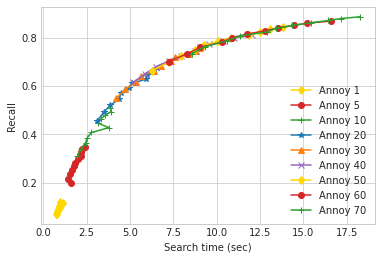

In [0]:
annoyVariations = annoyDetails['algorithm'].unique()
plt.style.use('seaborn-whitegrid')
plt.xlabel('Search time (sec)')
plt.ylabel('Recall')
for var in annoyVariations:
  variant = annoyDetails[annoyDetails.algorithm == var] 
  plt.plot(list(variant.searchTime),
           list(variant.recall), 
           label = 'Annoy '+str(variant.numTreesParam.iloc[0]), 
           color = next(colors), 
           marker = next(markers)
          )
  
plt.legend()
plt.show()
  
  

In [0]:
display(annoyDetails)

algorithm,constructionTime,searchTime,recall,avgDistance,numTreesParam,searchKparam,constructionClocks,searchClocks,Memory
Annoy-trees-1,28.053075108,0.7177264030000003,0.067641,298.66463092169863,1,50,28.27038428600281,0.7378841079989797,0.5700000000000003
Annoy-trees-1,28.053075108,0.770968216,0.068252,298.4650299893052,1,60,28.27038428600281,0.8542000359993835,0.5700000000000003
Annoy-trees-1,28.053075108,0.7628885919999959,0.072468,296.9706688528412,1,70,28.27038428600281,0.7634366460006277,0.5700000000000003
Annoy-trees-1,28.053075108,0.7880371480000008,0.080419,293.92789352822746,1,80,28.27038428600281,0.7859864650017698,0.5700000000000003
Annoy-trees-1,28.053075108,0.8506416580000007,0.088067,290.5665900759932,1,90,28.27038428600281,0.8586756179975055,0.5700000000000003
Annoy-trees-1,28.053075108,0.9353010850000061,0.09532,287.1274838321285,1,100,28.27038428600281,0.9348957980000705,0.5700000000000003
Annoy-trees-1,28.053075108,0.916058662999987,0.102403,283.7845624492245,1,110,28.27038428600281,0.915203497002949,0.5700000000000003
Annoy-trees-1,28.053075108,1.0226202789999945,0.10893,281.14289320323945,1,120,28.27038428600281,1.0449908030022925,0.5700000000000003
Annoy-trees-1,28.053075108,0.9757442930000053,0.115404,278.7167217918701,1,130,28.27038428600281,0.9749504669998714,0.5700000000000003
Annoy-trees-1,28.053075108,1.1123593770000042,0.117056,278.1630192263565,1,140,28.27038428600281,1.1623503159971733,0.5700000000000003


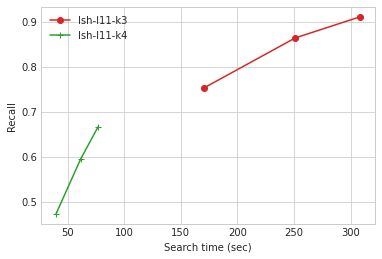

In [0]:
lshVariations = lsh['algorithm'].unique()
plt.style.use('seaborn-whitegrid')
plt.xlabel('Search time (sec)')
plt.ylabel('Recall')
for var in lshVariations:
  variant = lsh[lsh.algorithm == var] 
  plt.plot(list(variant.searchTime),
           list(variant.recall), 
           label = var,#+str(variant.numTreesParam.iloc[0]), 
           color = next(colors), 
           marker = next(markers)
          )
  
plt.legend()
plt.show()

In [0]:
display(lsh)

algorithm,constructionTime,searchTime,recall,avgDistance,constructionClocks,searchClocks,Memory,probes,hashes,tables
lsh-l11-k3,0.06253860499964503,170.52816005899876,0.752697,0,0.06380652500229189,170.197749698993,0.7500000000000009,11,3,11
lsh-l11-k3,0.06253860499964503,251.0140119660009,0.863618,0,0.06380652500229189,250.7275593650047,0.7500000000000009,11,3,22
lsh-l11-k3,0.06253860499964503,308.368087492001,0.910783,0,0.06380652500229189,308.0468018120009,0.7500000000000009,11,3,33
lsh-l11-k4,0.0010010679998231353,39.59012345299925,0.47131,0,0.001042203999531921,39.64704991100007,0.7500000000000009,11,4,11
lsh-l11-k4,0.0010010679998231353,61.5200655539993,0.594254,0,0.001042203999531921,61.492655711001134,0.7500000000000009,11,4,22
lsh-l11-k4,0.0010010679998231353,76.98417292700105,0.666236,0,0.001042203999531921,77.04857916399487,0.7500000000000009,11,4,33


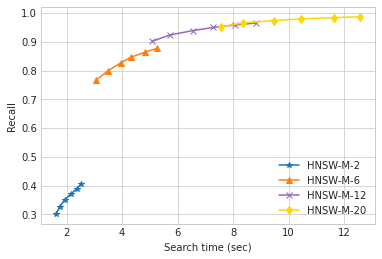

In [0]:
#hnswVariations = hnswDetails['algorithm'].apply(lambda x:str(x)[:8] ).unique()
hnswVariations = hnswDetails['Mparam'].unique()
plt.style.use('seaborn-whitegrid')
plt.xlabel('Search time (sec)')
plt.ylabel('Recall')
for var in hnswVariations:
  variant = hnswDetails[hnswDetails.Mparam == var] 
  plt.plot(list(variant.searchTime),
           list(variant.recall), 
           label = 'HNSW-M-'+str(var), 
           color = next(colors), 
           marker = next(markers)
          )
  
plt.legend()
plt.show()

In [0]:
display(hnswDetails)

algorithm,constructionTime,searchTime,recall,avgDistance,Mparam,efParams,constructionClocks,searchClocks,Memory
HNSW-M-2-ef-100,401.5302171500002,1.6116694740003368,0.299595,254.12429809570312,2,100,223.2546551330015,0.9848252440060605,1.2999999999999998
HNSW-M-2-ef-120,401.5302171500002,1.7520368430000417,0.326668,252.27011108398438,2,120,223.2546551330015,1.0564972739957739,1.2999999999999998
HNSW-M-2-ef-140,401.5302171500002,1.9356188020001355,0.350516,250.83518981933594,2,140,223.2546551330015,1.1540870250028092,1.2999999999999998
HNSW-M-2-ef-160,401.5302171500002,2.160317435000252,0.371172,249.7420196533203,2,160,223.2546551330015,1.2859458669991,1.2999999999999998
HNSW-M-2-ef-180,401.5302171500002,2.3696585090001463,0.389325,248.82765197753906,2,180,223.2546551330015,1.4002681450001546,1.2999999999999998
HNSW-M-2-ef-200,401.5302171500002,2.5330936290001773,0.405996,248.0557403564453,2,200,223.2546551330015,1.4959341900030267,1.2999999999999998
HNSW-M-6-ef-100,737.0931106039998,3.0675781859999915,0.766838,238.03456115722656,6,100,413.6863483990019,1.7922065239981748,0.9300000000000006
HNSW-M-6-ef-120,737.0931106039998,3.5061675819997618,0.800278,237.57022094726562,6,120,413.6863483990019,2.054493124000146,0.9300000000000006
HNSW-M-6-ef-140,737.0931106039998,3.9475119970002197,0.826449,237.2374725341797,6,140,413.6863483990019,2.409682633006014,0.9300000000000006
HNSW-M-6-ef-160,737.0931106039998,4.3298490900001525,0.846909,236.99905395507812,6,160,413.6863483990019,2.5371067819942255,0.9300000000000006


Out[48]: DataFrame[algorithm: string, constructionTime: string, searchTime: string, recall: string, avgDistance: string, constructionClocks: string, searchClocks: string, Memory: string]